In [1]:
from efficient_kan import KAN
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch
import mplhep as hep
hep.style.use("CMS")
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# device = 'cpu'

In [2]:
X_train=torch.from_numpy(np.load('data/X_train_val.npy')).float().to(device)
y_train=torch.from_numpy(np.load('data/y_train_val.npy')).float().to(device).argmax(dim=1)
X_test=torch.from_numpy(np.load('data/X_test.npy')).float().to(device)
y_test=torch.from_numpy(np.load('data/y_test.npy')).float().to(device).argmax(dim=1)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64  # Adjust this based on your available memory
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
model = KAN([16,4,5], grid_size=40, spline_order=4, grid_eps=0.03, base_activation=nn.GELU, grid_range=[-8,8])
print(sum(p.numel() for p in model.parameters()))

3864


In [4]:
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [5]:
training_loss = []
testing_loss = []

# Define loss
criterion = nn.CrossEntropyLoss()
for epoch in range(30):
    # Train
    model.train()
    epoch_train_loss = 0  # Initialize loss for the epoch
    total_batches = 0
    with tqdm(trainloader) as pbar:
        for i, (inputs, labels) in enumerate(pbar):
            inputs = inputs.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            total_batches += 1

            accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
    
    average_train_loss = epoch_train_loss / total_batches
    training_loss.append(average_train_loss)  # Record the average training loss

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            output = model(inputs)
            val_loss += criterion(output, labels.to(device)).item()
            val_accuracy += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss /= len(testloader)
    val_accuracy /= len(testloader)
    testing_loss.append(val_loss)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
    )

100%|██████████| 10375/10375 [00:20<00:00, 497.00it/s, accuracy=0.766, loss=0.695, lr=0.0001]


Epoch 1, Val Loss: 0.8232081719058794, Val Accuracy: 0.7182339854946298


100%|██████████| 10375/10375 [00:20<00:00, 500.94it/s, accuracy=0.609, loss=0.973, lr=9e-5]


Epoch 2, Val Loss: 0.7734619367669524, Val Accuracy: 0.726654860591006


100%|██████████| 10375/10375 [00:20<00:00, 501.42it/s, accuracy=0.781, loss=0.667, lr=8.1e-5]


Epoch 3, Val Loss: 0.7549980202016228, Val Accuracy: 0.7314475713184272


100%|██████████| 10375/10375 [00:20<00:00, 512.72it/s, accuracy=0.766, loss=0.531, lr=7.29e-5]


Epoch 4, Val Loss: 0.7450445735210993, Val Accuracy: 0.7346641287586738


100%|██████████| 10375/10375 [00:19<00:00, 532.76it/s, accuracy=0.719, loss=0.71, lr=6.56e-5] 


Epoch 5, Val Loss: 0.7380709398017999, Val Accuracy: 0.7371960132509907


100%|██████████| 10375/10375 [00:19<00:00, 526.22it/s, accuracy=0.734, loss=0.713, lr=5.9e-5]


Epoch 6, Val Loss: 0.7326885181132333, Val Accuracy: 0.7393283378462104


100%|██████████| 10375/10375 [00:20<00:00, 514.98it/s, accuracy=0.719, loss=0.848, lr=5.31e-5]


Epoch 7, Val Loss: 0.7285641823007036, Val Accuracy: 0.7413642861885389


100%|██████████| 10375/10375 [00:19<00:00, 533.49it/s, accuracy=0.734, loss=0.778, lr=4.78e-5]


Epoch 8, Val Loss: 0.7253236422055303, Val Accuracy: 0.7425890677280397


100%|██████████| 10375/10375 [00:20<00:00, 514.11it/s, accuracy=0.75, loss=0.653, lr=4.3e-5] 


Epoch 9, Val Loss: 0.7226107060082068, Val Accuracy: 0.7437857395424324


100%|██████████| 10375/10375 [00:19<00:00, 526.08it/s, accuracy=0.719, loss=0.794, lr=3.87e-5]


Epoch 10, Val Loss: 0.7204588060550903, Val Accuracy: 0.7446972982600366


100%|██████████| 10375/10375 [00:20<00:00, 509.01it/s, accuracy=0.859, loss=0.513, lr=3.49e-5]


Epoch 11, Val Loss: 0.7185903016015394, Val Accuracy: 0.7454562612515555


100%|██████████| 10375/10375 [00:20<00:00, 499.44it/s, accuracy=0.75, loss=0.65, lr=3.14e-5]  


Epoch 12, Val Loss: 0.7170534743169867, Val Accuracy: 0.7459803071266519


100%|██████████| 10375/10375 [00:20<00:00, 499.39it/s, accuracy=0.734, loss=0.788, lr=2.82e-5]


Epoch 13, Val Loss: 0.7156795294310556, Val Accuracy: 0.7465344705807767


100%|██████████| 10375/10375 [00:20<00:00, 508.10it/s, accuracy=0.766, loss=0.647, lr=2.54e-5]


Epoch 14, Val Loss: 0.7144311504839197, Val Accuracy: 0.7469621402029818


100%|██████████| 10375/10375 [00:19<00:00, 531.40it/s, accuracy=0.734, loss=0.716, lr=2.29e-5]


Epoch 15, Val Loss: 0.7134644972101578, Val Accuracy: 0.7472934335722956


100%|██████████| 10375/10375 [00:19<00:00, 536.11it/s, accuracy=0.75, loss=0.676, lr=2.06e-5] 


Epoch 16, Val Loss: 0.7125837008885999, Val Accuracy: 0.7475584682677466


100%|██████████| 10375/10375 [00:19<00:00, 536.89it/s, accuracy=0.812, loss=0.574, lr=1.85e-5]


Epoch 17, Val Loss: 0.7118182536401285, Val Accuracy: 0.7479499967951175


100%|██████████| 10375/10375 [00:19<00:00, 538.06it/s, accuracy=0.797, loss=0.677, lr=1.67e-5]


Epoch 18, Val Loss: 0.7111052616385193, Val Accuracy: 0.7481788903957344


100%|██████████| 10375/10375 [00:19<00:00, 524.80it/s, accuracy=0.797, loss=0.627, lr=1.5e-5]


Epoch 19, Val Loss: 0.7105374925280867, Val Accuracy: 0.7483355018066827


100%|██████████| 10375/10375 [00:20<00:00, 516.39it/s, accuracy=0.656, loss=0.986, lr=1.35e-5]


Epoch 20, Val Loss: 0.7100144565886687, Val Accuracy: 0.7486125835337452


100%|██████████| 10375/10375 [00:20<00:00, 517.24it/s, accuracy=0.797, loss=0.646, lr=1.22e-5]


Epoch 21, Val Loss: 0.7095672942945014, Val Accuracy: 0.7486728186918022


100%|██████████| 10375/10375 [00:20<00:00, 497.20it/s, accuracy=0.812, loss=0.568, lr=1.09e-5]


Epoch 22, Val Loss: 0.709143698755465, Val Accuracy: 0.7487691949446935


100%|██████████| 10375/10375 [00:20<00:00, 502.05it/s, accuracy=0.719, loss=0.818, lr=9.85e-6]


KeyboardInterrupt: 

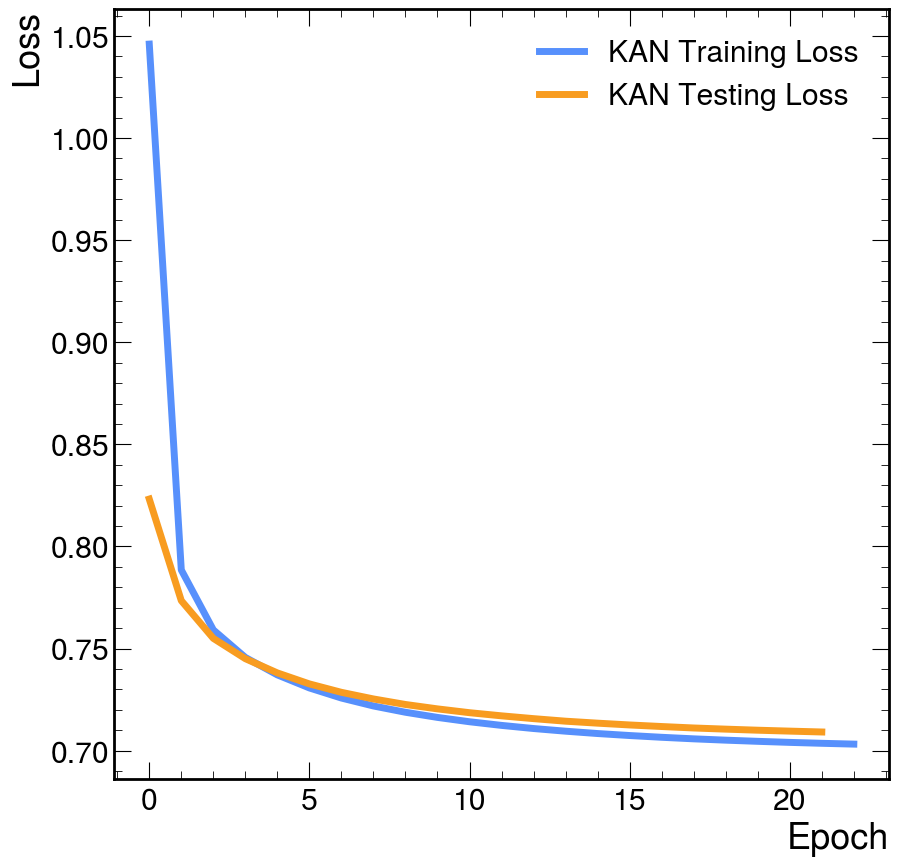

In [6]:
plt.plot(training_loss, label='KAN Training Loss',linewidth=5)
plt.plot(testing_loss, label='KAN Testing Loss',linewidth=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [8]:
torch.save(model, "mini_kan.pt")